In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os
import random
from tqdm import tqdm
import seaborn as sns

import torch
import torchmetrics
from torch.utils.data import Dataset

from PIL import Image
import ultralytics
ultralytics.checks()

from ultralytics import YOLO
%matplotlib inline

Ultralytics YOLOv8.0.168  Python-3.9.17 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 12288MiB)
Setup complete  (20 CPUs, 31.7 GB RAM, 199.1/1863.0 GB disk)


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Available device:{}'.format(device))

Available device:cuda:0


In [3]:
TRAIN_PATH = r"A:\Datasets\Drone_eval\Drone_data_cleaned_2k+planes\train"
TEST_PATH = r"A:\Datasets\Drone_eval\Drone_data_cleaned_2k+planes\val"

DATASET_PATH = r"A:\Datasets\Drone_eval\Drone_data_cleaned_2k+planes\uav_dataset_clean.yaml"
SEED = 42

MODEL_PATH = r"A:\Jupyter Files\UHV\runs\detect\UAV_100e_CLEAN+planes_012\weights\last.pt"

In [4]:
def yolobbox2bbox(bbox_list, img_shape):
    x, y, w, h = bbox_list
    x, w = x*img_shape[1], w*img_shape[1]
    y, h = y*img_shape[0], h*img_shape[0]
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return list(map(int, [x1, y1, x2, y2]))

def compute_iou(prediction_bbox: list[float], target_bbox: list[float]):

    n_pred = len(prediction_bbox)
    n_targets = len(target_bbox)

    if  n_pred and n_targets:
        preds = [
            {
            'boxes': torch.tensor([prediction_bbox]),
            'scores': torch.tensor([1.]),
            'labels': torch.tensor([0.])
            }
        ]
        targets = [
            {
                'boxes': torch.tensor([target_bbox]),
                'labels': torch.tensor([0.])
            }
        ]

        score = iou_metric(preds, targets)

        return score['iou'].item()

    return 0.

def tp_estimation(target_bboxes, pred_bboxes, threshold=0.6):
    n_target = len(target_bboxes)
    n_pred = len(pred_bboxes)
    is_correct = np.zeros(n_pred)

    if n_pred:
        for i, pred in enumerate(pred_bboxes):
            if n_target:
                for target in target_bboxes:
                    if compute_iou(pred, target) > threshold:
                        is_correct[i] = 1
                        target_bboxes.remove(target)
                        break

    return is_correct

# Data preview
Train and test sets have been taken from a different UAV datasets and do not intersect.
For model training, I used a custom dataset, which consists of 2700 hand-labeled images and 5000 background images, taken mostly from YouTube videos and other open sources. Background images are the ones with planes, one/two-rotor helicopters and birds.
*Let's take a look.*

In [19]:
files_list = os.listdir(TRAIN_PATH)

jpg_list = []
txt_list = []

for file_name in files_list:
    if file_name.endswith('.jpg'):
        jpg_list.append(file_name)
    else:
        txt_list.append(file_name)

print(f'Train Dataset size is {len(txt_list)} labeled images and {len(jpg_list)-len(txt_list)} background images')

Train Dataset size is 2728 labeled images and 4799 background images


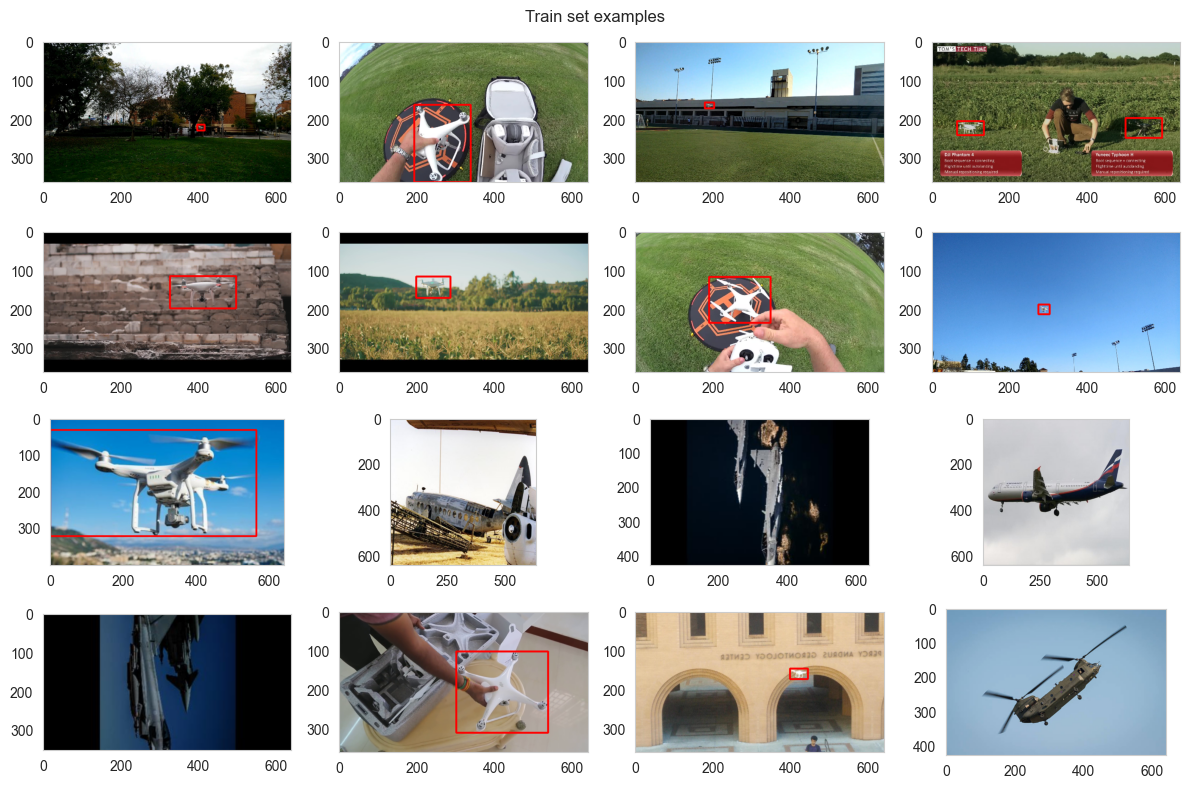

In [37]:
plot_row = 4
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,8), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        rand_path = os.path.join(TRAIN_PATH, random.choice(jpg_list).rstrip('.jpg'))

        image = cv.imread(rand_path + '.jpg')
        width = 640
        height = int(image.shape[0] / (image.shape[1]/width))

        image = cv.resize(image, dsize=(width, height))
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        txt_name = rand_path + '.txt'

        if os.path.basename(txt_name) in txt_list:
            with open(txt_name, encoding='utf-8') as f:
                coord_file = f.readlines()

            for bbox_coord in coord_file:
                bbox_coord = bbox_coord.strip()
                b_list = list(map(float, bbox_coord.split()[1:]))
                b_list = yolobbox2bbox(b_list, image.shape)

                image = cv.rectangle(image, (b_list[0], b_list[1]), (b_list[2], b_list[3]),
                          color=(255,0,0), thickness=4)

        axs[i, j].imshow(image)
        axs[i, j].grid(False)

fig.suptitle('Train set examples')
plt.show()

So, the *Train dataset* consists of images of mainly commercially available drones, like DJI Phantom, Mavic as well as the smaller and bigger models.

The *Test dataset* labeled part is taken from kaggle [Drone Object Detection](https://www.kaggle.com/datasets/sshikamaru/drone-yolo-detection).
Dataset consists of more than 4000 drone images, but a lot of them, sadly, were not labeled.

In [13]:
files_test_list = os.listdir(TEST_PATH)

jpg_test_list = []
txt_test_list = []

for file_name in files_test_list:
    if file_name.endswith('.jpg'):
        jpg_test_list.append(file_name)
    else:
        txt_test_list.append(file_name)

print(f'Train Dataset size is {len(txt_test_list)} labeled images and \
{len(jpg_test_list)-len(txt_test_list)} background images')

Train Dataset size is 2868 labeled images and 5434 background images


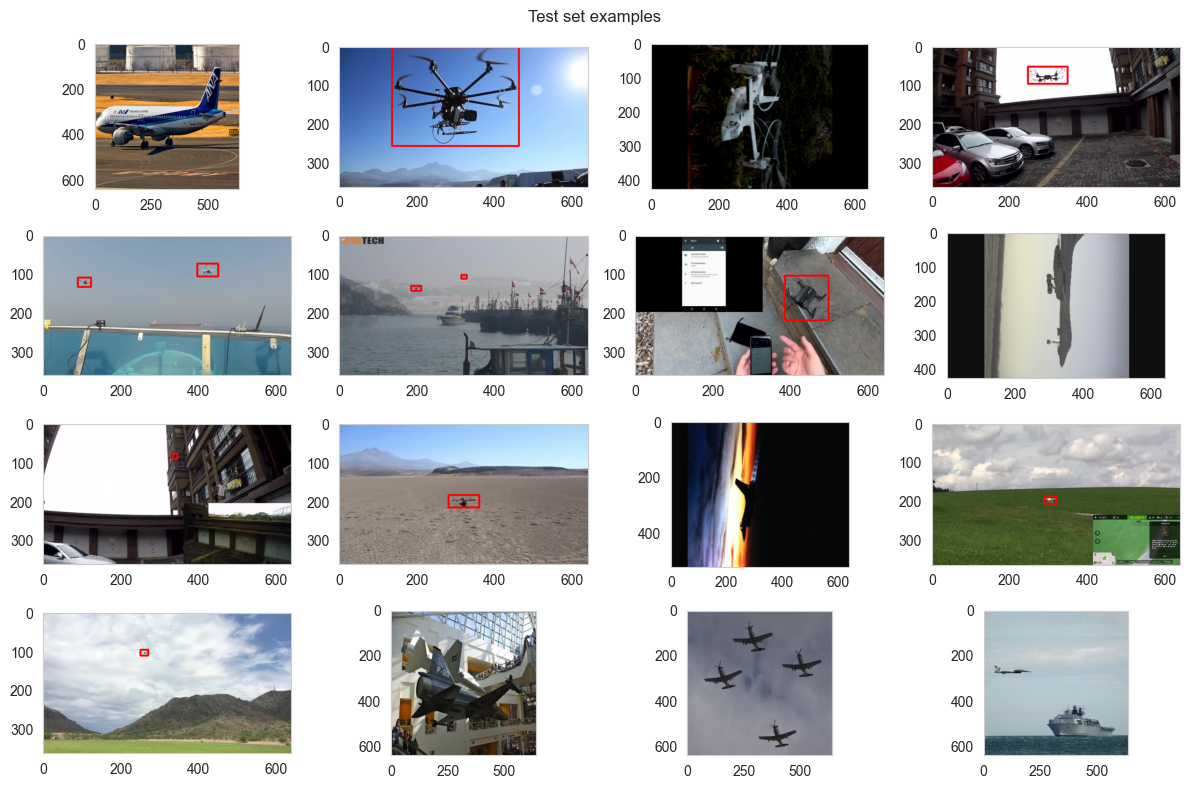

In [27]:
plot_row = 4
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,8), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        rand_path = os.path.join(TEST_PATH, random.choice(jpg_test_list).rstrip('.jpg'))

        image = cv.imread(rand_path + '.jpg')
        width = 640
        height = int(image.shape[0] / (image.shape[1]/width))

        image = cv.resize(image, dsize=(width, height))
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        txt_test_name = rand_path + '.txt'

        if os.path.basename(txt_test_name) in txt_test_list:
            with open(txt_test_name, encoding='utf-8') as f:
                coord_file = f.readlines()

            for bbox_coord in coord_file:
                bbox_coord = bbox_coord.strip()
                b_list = list(map(float, bbox_coord.split()[1:]))
                b_list = yolobbox2bbox(b_list, image.shape)

                image = cv.rectangle(image, (b_list[0], b_list[1]), (b_list[2], b_list[3]),
                            color=(255,0,0), thickness=4)

        axs[i, j].imshow(image)
        axs[i, j].grid(False)

fig.suptitle('Test set examples')
plt.show()

# Model validation
Next, let's import our model and see how it performs.
The model is pre-trained Yolov8 large architecture, fine-tuned on Train dataset for 100 epochs.

### 1. First, let's create a Dataset class for image/bounding box import:

In [5]:
class ValDataset(Dataset):
    def __init__(self, test_path=TEST_PATH):
        self.test_path = test_path
        self.files_list = os.listdir(test_path)
        self.jpg_list = []
        self.txt_list = []

    def __len__(self):
        return len(self.jpg_list)

    @property
    def jpg_list(self):
        return self.__jpg_list

    @jpg_list.setter
    def jpg_list(self, val):
        self.__jpg_list = val
        for file_name in self.files_list:
            if file_name.endswith('.jpg'):
                self.__jpg_list.append(file_name)

    @property
    def txt_list(self):
        return self.__txt_list

    @txt_list.setter
    def txt_list(self, val):
        self.__txt_list = val
        for file_name in self.files_list:
            if file_name.endswith('.txt'):
                self.__txt_list.append(file_name)

    def get_bbox(self, name, path, shape):
        target_bboxes = []

        if name in self.files_list:
            with open(path, encoding='utf-8') as f:
                bboxes = f.readlines()

            for bb in bboxes:
                bbox = list(map(float, bb.split()[1:]))
                bbox = yolobbox2bbox(bbox, shape)
                target_bboxes.append(bbox)

        return target_bboxes

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self):
            raise StopIteration
        img, bbx = self.__getitem__(self.i)
        name = self.jpg_list[self.i]

        self.i += 1

        return img, bbx, name

    def __getitem__(self, index):
        image_name = self.jpg_list[index]
        txt_name = image_name[:-3]+'txt'

        image_path = os.path.join(self.test_path, image_name)
        bbox_path = os.path.join(self.test_path, txt_name)

        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        bbox = self.get_bbox(txt_name, bbox_path, image.shape)

        return image, bbox

In [6]:
val_dataset = ValDataset()
iou_metric = torchmetrics.detection.IntersectionOverUnion(box_format='xyxy', iou_threshold=0.5)
model = YOLO(MODEL_PATH)

### 2. Next, make predictions, compare them to the ground truth bboxes, and count *True positive*, *False positive* and *False negative* predictions.

In [26]:
n_targets = 0
conf = np.array([])
is_correct = np.array([])
names = []

for i , (val_image, targets_bboxes, image_name) in enumerate(tqdm(val_dataset)):
    n_targets += len(targets_bboxes)

    y_hat = model.predict(val_image, iou=0.5, verbose=False, conf=0.0001)

    predicted_bbox = y_hat[0].boxes.xyxy.cpu().numpy()
    prediction_conf = y_hat[0].boxes.conf.cpu().numpy()

    is_correct_list = tp_estimation(targets_bboxes, predicted_bbox)

    conf = np.concatenate((conf, prediction_conf))
    is_correct = np.concatenate((is_correct, is_correct_list))
    names = names + [image_name]*len(prediction_conf)

scores_df = pd.DataFrame.from_dict({'name': names, 'conf': conf, 'TP': is_correct})

100%|██████████| 8302/8302 [02:24<00:00, 57.61it/s]


In [27]:
sorted_scores_df = scores_df.sort_values(by='conf', ascending=False).reset_index(drop=True)
sorted_scores_df.conf = sorted_scores_df.conf.round(2)
sorted_scores_df.TP = sorted_scores_df.TP.astype(int)

### 3. Let's take a look at some high-confidence predictions, which the model got wrong.

In [28]:
misclassified = sorted_scores_df[(sorted_scores_df.conf > 0.7) & (sorted_scores_df.TP == 0)]

misclassified.head()

,name,conf,TP
20,video16_395.jpg,0.95,0
61,video16_393.jpg,0.95,0
93,video16_397.jpg,0.94,0
257,video16_392.jpg,0.93,0
284,e75623014c2a9488_jpg.rf.fa1599fa88ac26439994a7...,0.93,0


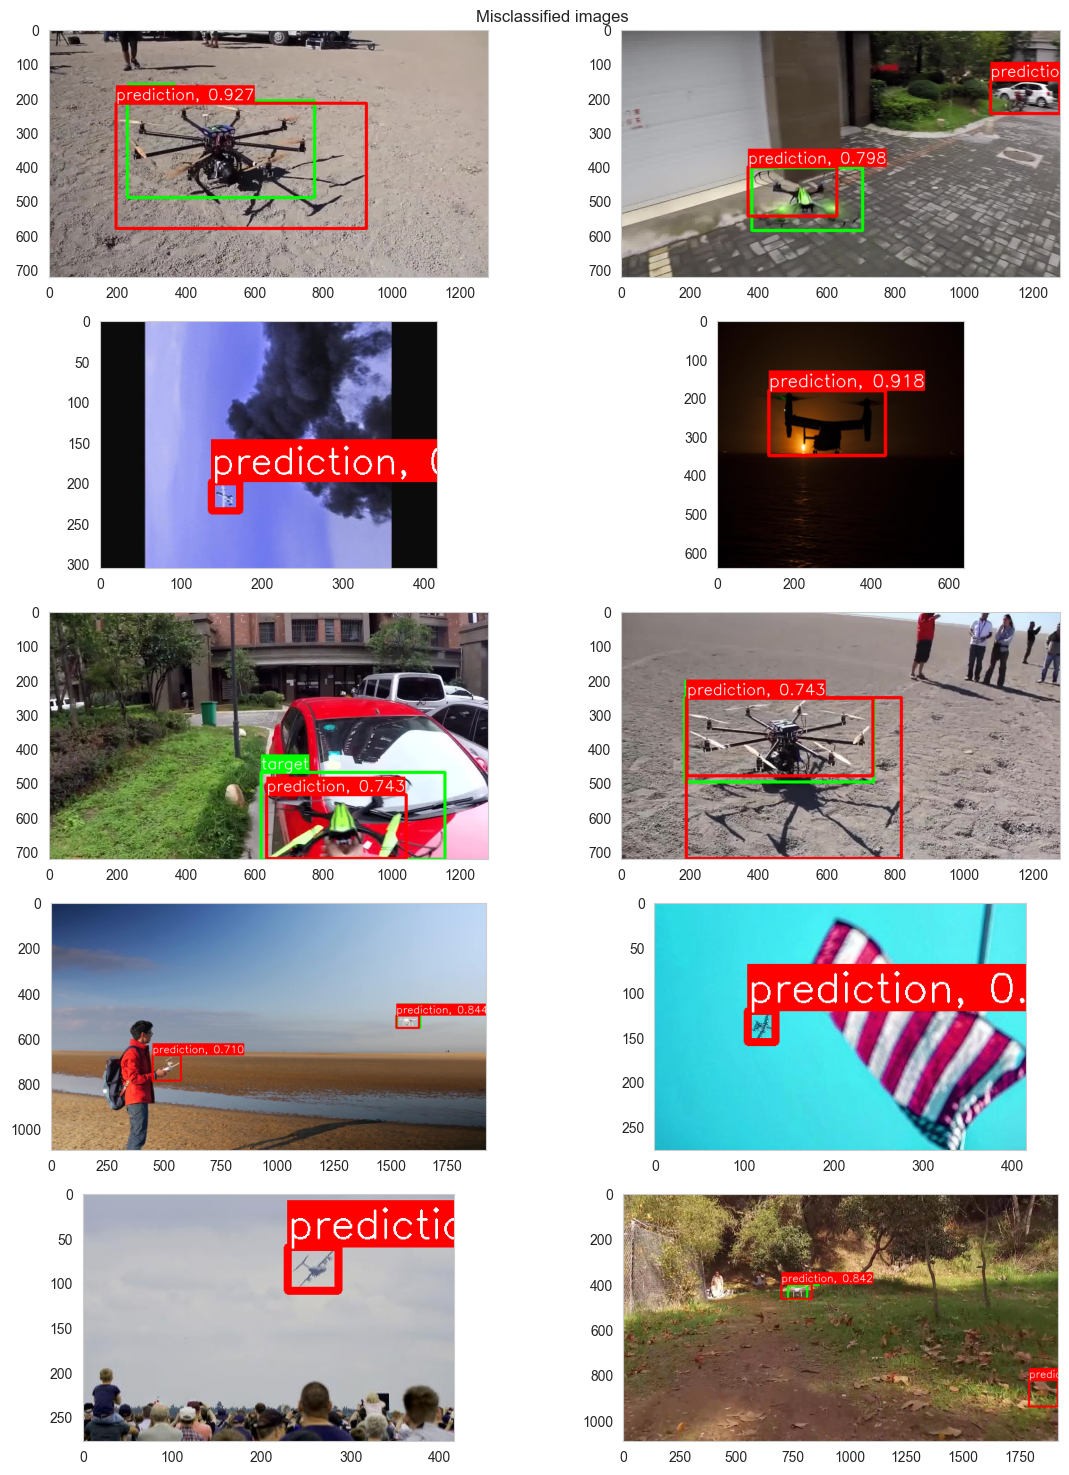

In [41]:
plot_row = 5
plot_col = 2

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,15), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        mis_name = np.random.choice(misclassified.name, replace=False)
        mis_image = cv.imread(os.path.join(TEST_PATH, mis_name))
        mis_image = cv.cvtColor(mis_image, cv.COLOR_RGB2BGR)

        y_hat = model.predict(mis_image, iou=0.5, verbose=False, conf=0.4)

        bbox_path = mis_name[:-3] + 'txt'

        if bbox_path in files_test_list:
            with open(os.path.join(TEST_PATH, bbox_path), encoding='utf-8') as f:
                bboxes = f.readlines()

            for bb in bboxes:
                bbox = list(map(float, bb.split()[1:]))
                bbox = yolobbox2bbox(bbox, mis_image.shape)

                mis_image = cv.rectangle(mis_image, bbox[:2], bbox[2:],
                                        color=(0,255,0), thickness=8)

                (w, h), _ = cv.getTextSize('target', cv.FONT_HERSHEY_SIMPLEX, 1.5, 1)
                mis_image = cv.rectangle(mis_image, (bbox[:2][0], bbox[:2][1]-h - 20),
                                        (bbox[:2][0] + w, bbox[:2][1]), (0,255,0), -1 )

                cv.putText(mis_image, 'target', (bbox[0], bbox[1]-10),
                            cv.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)

        predicted_bbox = y_hat[0].boxes.xyxy.cpu().numpy()
        prediction_conf = y_hat[0].boxes.conf.cpu()

        for k, prediction in enumerate(predicted_bbox):
            pt1 = tuple(map(int, prediction[:2]))
            pt2 = tuple(map(int, prediction[2:]))

            text = f'prediction, {prediction_conf[k]:.3f}'

            mis_image = cv.rectangle(mis_image, pt1, pt2, color=(255,0,0), thickness=8)
            (w, h), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 1.5, 1)
            mis_image = cv.rectangle(mis_image, (pt1[0], pt1[1]-h - 20),
                                (pt1[0] + w, pt1[1]), (255,0,0), -1 )
            mis_image = cv.putText(mis_image, text, (pt1[0], pt1[1]-10),
                                cv.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)

        axs[i,j].imshow(mis_image)
        axs[i,j].grid(False)

fig.suptitle('Misclassified images')
plt.show()

We can see that the model got wrong mainly some small planes/helicopters in the sky, hard shadows. So, the instances that are really hard to classify.

### 4. Next, we'll take a look at a *Confusion Matrix*.

In [30]:
sorted_scores_df = sorted_scores_df.drop('name', axis=1)
grouped_df = sorted_scores_df.groupby('conf').sum().reset_index()
grouped_df['FP'] = sorted_scores_df.groupby('conf').count().values

grouped_df.FP = grouped_df.FP - grouped_df.TP
grouped_df = grouped_df.sort_values(by='conf', ascending=False).reset_index(drop=True)

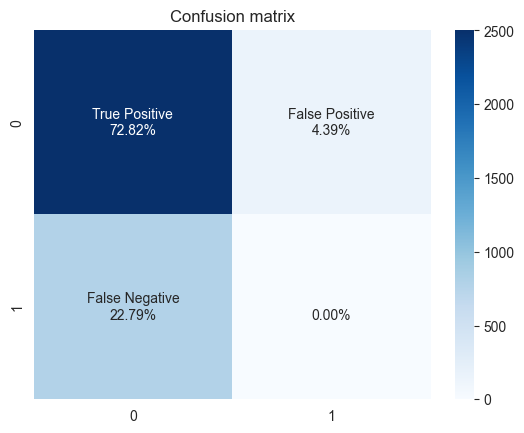

In [42]:
max_index = grouped_df.index[grouped_df.conf == 0.48].item()

tp = grouped_df.TP[:max_index].sum()
fp = grouped_df.FP[:max_index].sum()
fn = n_targets - tp

cm = np.array([[tp, fp],[fn, 0]])
cm_names = ['True Positive', 'False Positive', 'False Negative', '']

cm_labels = [f'{cm_name}\n{n/np.sum(cm):.2%}' for cm_name, n in zip(cm_names, cm.flatten())]
cm_labels = np.asarray(cm_labels).reshape(2,2)
fig = sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues')
fig.set_title('Confusion matrix')
plt.show()

### 5. And finally, calculate *mAP* and *F1* scores for the model.

In [31]:
precision = np.zeros(len(grouped_df))
recall = np.zeros(len(grouped_df))
f1_score = np.zeros(len(grouped_df))

for i in grouped_df.index:
    j=i+1
    precision[i] = grouped_df.TP[:j].sum() / (grouped_df.TP[:j].sum() + grouped_df.FP[:j].sum())
    recall[i] = grouped_df.TP[:j].sum() / n_targets
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

grouped_df['Precision'] = precision
grouped_df['Recall'] = recall
grouped_df['F1_score'] = f1_score

ap = grouped_df.Precision.mean()

In [32]:
grouped_df.head()

,conf,TP,FP,Precision,Recall,F1_score
0,0.97,1,0,1.000000,0.000304,0.000608
1,0.96,11,0,1.000000,0.003649,0.007271
2,0.95,79,2,0.978495,0.027668,0.053814
3,0.94,158,1,0.988095,0.075707,0.140638
4,0.93,128,3,0.984334,0.114625,0.205338


mAP@50: 0.909
F1 score: 0.843


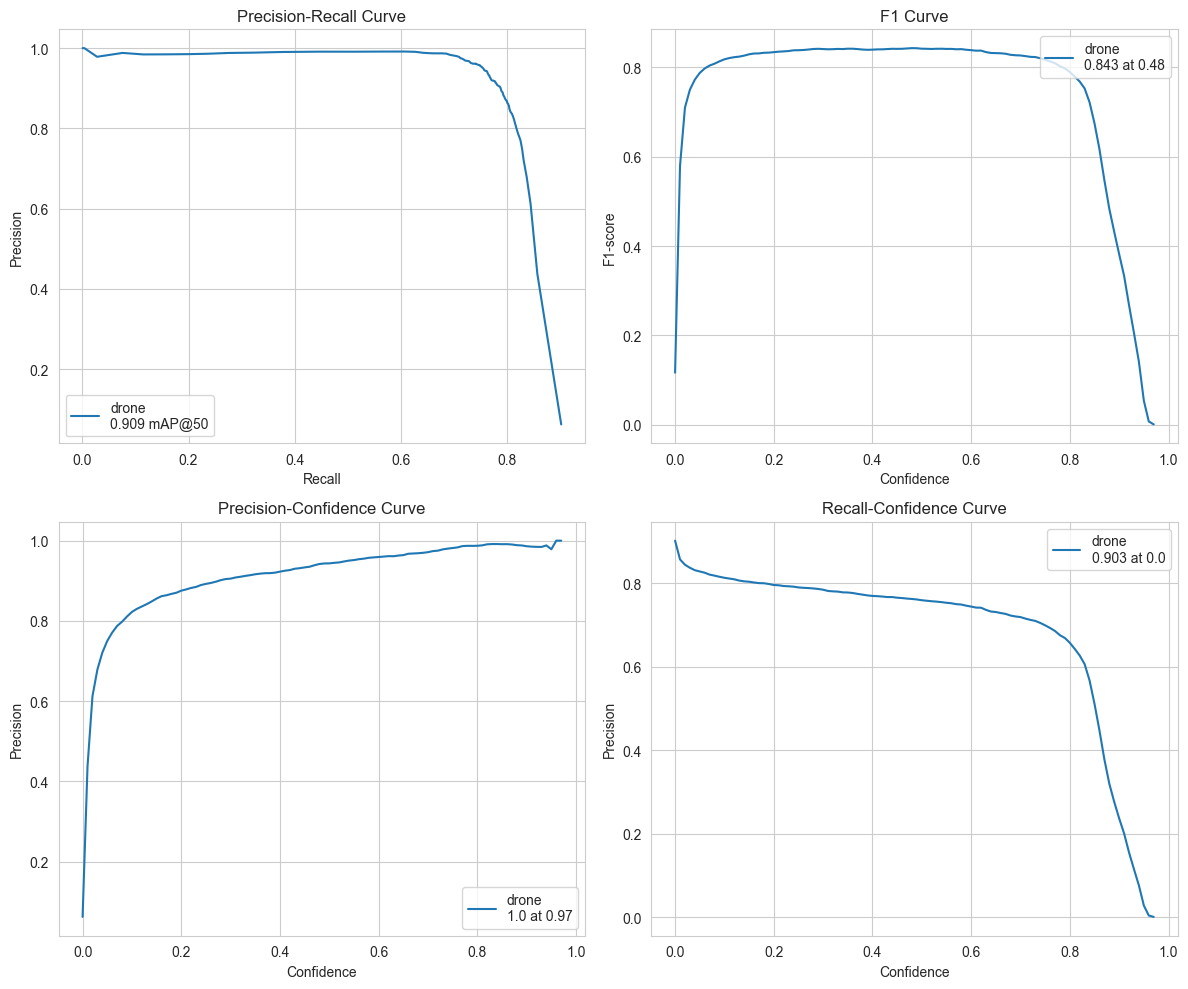

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), layout='tight')

axs[0,0].plot(grouped_df.Recall, grouped_df.Precision, label=f'drone\n{ap:.3f} mAP@50')
axs[0,0].set_xlabel('Recall')
axs[0,0].set_ylabel('Precision')
axs[0,0].set_title('Precision-Recall Curve')
axs[0,0].legend(loc='lower left')

axs[0,1].plot(grouped_df.conf, grouped_df.F1_score, label=f'drone\n{grouped_df.F1_score.max():.3f} at \
{grouped_df.conf[grouped_df.F1_score == grouped_df.F1_score.max()].item()}')
axs[0,1].set_xlabel('Confidence')
axs[0,1].set_ylabel('F1-score')
axs[0,1].set_title('F1 Curve')
axs[0,1].legend(loc='upper right')

axs[1,0].plot(grouped_df.conf, grouped_df.Precision, label=f'drone\n{grouped_df.Precision.max()} at \
{grouped_df.conf[grouped_df.Precision == grouped_df.Precision.max()][0]}')
axs[1,0].set_xlabel('Confidence')
axs[1,0].set_ylabel('Precision')
axs[1,0].set_title('Precision-Confidence Curve')
axs[1,0].legend(loc='lower right')

axs[1,1].plot(grouped_df.conf, grouped_df.Recall, label=f'drone\n{grouped_df.Recall.max():.3f} at \
{grouped_df.conf[grouped_df.Recall == grouped_df.Recall.max()].item()}')
axs[1,1].set_xlabel('Confidence')
axs[1,1].set_ylabel('Precision')
axs[1,1].set_title('Recall-Confidence Curve')
axs[1,1].legend(loc='upper right')

print(f'mAP@50: {ap:.3f}\nF1 score: {grouped_df.F1_score.max():.3f}')
plt.show()